In [1]:
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [4]:
# # nltk
# import nltk
# nltk.download()

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


True

In [2]:
import pandas as pd
import numpy as np
import itertools
import re
# nltk
import nltk
# sklearn
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
# gensim
from gensim.utils import simple_preprocess, dict_from_corpus
from gensim.models import LdaModel, TfidfModel
from gensim.models.phrases import Phrases, Phraser
from gensim.corpora import Dictionary
from gensim.parsing.preprocessing import preprocess_string, preprocess_documents


%matplotlib inline

2018-08-01 14:11:28,446 : INFO : 'pattern' package not found; tag filters are not available for English


## NLTK

### gutenberg corpus

In [3]:
import nltk
nltk.corpus.gutenberg.fileids()
for fileid in nltk.corpus.gutenberg.fileids():
    num_chars = len(nltk.corpus.gutenberg.raw(fileid))
    num_words = len(nltk.corpus.gutenberg.words(fileid))
    num_sents = len(nltk.corpus.gutenberg.sents(fileid))
    num_vocab = len(set([w.lower() for w in nltk.corpus.gutenberg.words(fileid)]))
    print(int(num_chars/num_words), int(num_words/num_sents), int(num_words/num_vocab), fileid)

4 24 26 austen-emma.txt
4 26 16 austen-persuasion.txt
4 28 22 austen-sense.txt
4 33 79 bible-kjv.txt
4 19 5 blake-poems.txt
4 19 14 bryant-stories.txt
4 17 12 burgess-busterbrown.txt
4 20 12 carroll-alice.txt
4 20 11 chesterton-ball.txt
4 22 11 chesterton-brown.txt
4 18 10 chesterton-thursday.txt
4 20 24 edgeworth-parents.txt
4 25 15 melville-moby_dick.txt
4 52 10 milton-paradise.txt
4 11 8 shakespeare-caesar.txt
4 12 7 shakespeare-hamlet.txt
4 12 6 shakespeare-macbeth.txt
4 36 12 whitman-leaves.txt


### Brown corpus

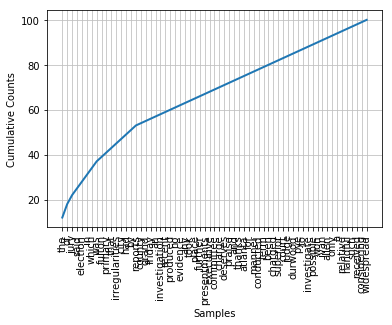

In [188]:
from nltk.corpus import brown
news_text = brown.words(categories='news')
fdist = nltk.FreqDist([w.lower() for w in news_text if w.isalnum()][:100])
fdist.plot(cumulative=True)

### some basic inspection utils

Displaying 25 of 25 matches:
artsfield announced that he would not run for reelection . Georgia Republicans 
 that medical benefits paid out would run 1 billion or more in the first year ,
 , R-Cape May , said today Jones will run well ahead of his GOP opponents for t
ny the reports that he had decided to run and wanted Mr. Screvane , who lives i
 of investigation . Street car tracks run down the center of Pennsylvania , pow
ntral esplanade that would eventually run through the center of the entire two-
ss with what proved to be the winning run . Rookie southpaw George Stepanovich 
27-minute contest . The Orioles got a run in the first inning when Breeding , a
n , set a meet record in the 600-yard run in the Knights of Columbus track meet
eek-old world record in the half-mile run . Mrs. Grace Butcher , of nearby Char
and then uncorked a 56-yard touchdown run before retiring to the bench . Wingba
oking a lot better , and he's able to run '' , Meek explained . `` We'll let hi
 tallies . 

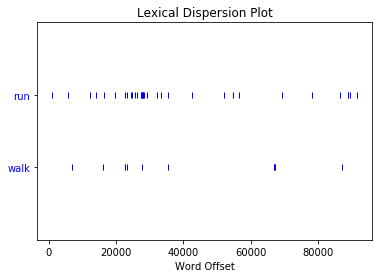

In [196]:
### some utils for EDA
news_text = nltk.Text(news_text)
# get context of appearance
news_text.concordance("run")
# get similar concordance (word in simular context)
news_text.similar("run")
# get shared-context
news_text.common_contexts(["run", "away"])
# get dispersion plot
news_text.dispersion_plot(["run", "walk"])
# 

### conditional freq (good for topic diagnosis / bi-gram coexist)

In [206]:
from nltk.corpus import brown
# get a list of tuple 
genre_word = [
    (genre, word) 
    for genre in ['news', 'romance'] 
    for word in brown.words(categories=genre)
]
genre_word[:4]

[('news', 'The'), ('news', 'Fulton'), ('news', 'County'), ('news', 'Grand')]

In [231]:
cfd = nltk.ConditionalFreqDist(genre_word)
# get conditions
cfd.conditions()
# get freq dist for one topic
cfd['news'].most_common()[:10]

[('the', 5580),
 (',', 5188),
 ('.', 4030),
 ('of', 2849),
 ('and', 2146),
 ('to', 2116),
 ('a', 1993),
 ('in', 1893),
 ('for', 943),
 ('The', 806)]

In [218]:
# table for cond freq
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
cfd.tabulate(conditions=['news', 'romance'], samples=days, cumulative=False)

           Monday   Tuesday Wednesday  Thursday    Friday  Saturday    Sunday 
   news        54        43        22        20        41        33        51 
romance         2         3         3         1         3         4         5 


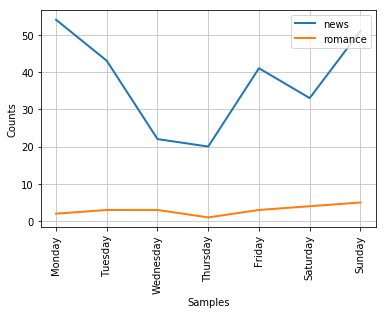

In [219]:
# plot for cond freq
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
cfd.plot(conditions=['news', 'romance'], samples=days, cumulative=False)

### text generation (dummy) based on conditional freq of bi-gram pairs

In [227]:
# some random texts
sent = ['In', 'the', 'beginning', 'God', 'created', 'the', 'heaven', 'and', 'the', 'earth', '.']
# get cond freq from nltk
cfd = nltk.ConditionalFreqDist(list(nltk.bigrams(sent)))
# define maximize freq for bi-gram for text generation  --- tends to stuck in the loop
def generate_model(cfdist, word, num=15):
    for i in range(num):
        print(word)
        word = cfdist[word].max()
# run text generation
generate_model(cfdist=cfd, word='the', num=8)

the
beginning
God
created
the
beginning
God
created


### Loading Your Own Corpus

In [3]:
with open('./AAPL_wiki_page.txt', 'w') as f:
    f.write(wikipedia.page('Apple Inc.').content)

In [4]:
from nltk.corpus import PlaintextCorpusReader
corpus_root = './'
wordlists = PlaintextCorpusReader(corpus_root, '.*\.txt')
wordlists.fileids()
wordlists.words('AAPL_wiki_page.txt')

['Apple', 'Inc', '.', 'is', 'an', 'American', ...]

### NLTK --- Lexical Resources

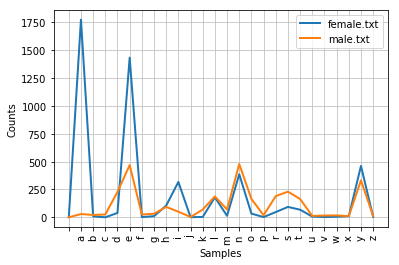

'I'

In [36]:
# 1. Wordlist Corpora -- English Vocab
def unusual_words(text):
    text_vocab = set(w.lower() for w in text if w.isalpha())
    english_vocab = set(w.lower() for w in nltk.corpus.words.words())
    unusual = text_vocab.difference(english_vocab)
    return sorted(unusual)
## nps_chat corpus
unusual_words(nltk.corpus.nps_chat.words())[:5]
## AAPL wiki pages
unusual_words(wordlists.words('AAPL_wiki_page.txt'))[:10]


# 2. Stop words
from nltk.corpus import stopwords
stopwords.words('english')[:5]
## calc frac of non stopwords ---- usually we can filter out 1/3 (of stopwords) of text
def content_fraction(text):
    stopwords = nltk.corpus.stopwords.words('english')
    content = [w for w in text if w.lower() not in stopwords]
    return len(content) / len(text)
content_fraction(wordlists.words('AAPL_wiki_page.txt'))


# 3. Name Corpus
name_corpus = nltk.corpus.names
name_corpus.fileids()
male_names = name_corpus.words('male.txt')
female_names = name_corpus.words('female.txt')
[w for w in male_names if w in female_names][:5]
## female have more names that end at letter 'a'
cfd = nltk.ConditionalFreqDist(
    (fileid, name[-1])
    for fileid in name_corpus.fileids()
    for name in name_corpus.words(fileid)
)
cfd.plot()

# 4. Pronouncing Dictionary -- for speech synthesizers
## entries of all words in wordlist
entries = nltk.corpus.cmudict.entries()
len(entries)
entries[8000:8010]
## dictionray of all words in wordlist
prondict = nltk.corpus.cmudict.dict()
prondict['fire']


# 5. Comparative Wordlists  -- for language translation
from nltk.corpus import swadesh
swadesh.fileids()
fr2en = swadesh.entries(['fr', 'en'])
## a list of tuples [('French word', 'English word)]
fr2en[:5]
## turn into dictionary for easier lookup
translate = dict(fr2en)
translate['je']


# 6. Word Net  --- a dictionary for 
from nltk.corpus import wordnet
## Basic navigation
## get a list of synsets of a word  --- synonym set
syn_list = wordnet.synsets('man')
syn_list
## get a list of lemmas of a synset
lemma_list = wordnet.synset('man.n.01').lemmas()
## get hyponyms (list of subordinate concepts) of a synset
wordnet.synset('man.n.01').hyponyms()
## get hypernyms (list of superordinate concepts) of a synset
wordnet.synset('man.n.01').hypernyms()
## get hypernyms path
wordnet.synset('man.n.01').hypernym_paths()
## get root hypernyms of a syncets
wordnet.synset('man.n.01').root_hypernyms()

# MORE lexical relation
## get components of a entity
wordnet.synset('man.n.01').part_meronyms()
## get substance of a entity
wordnet.synset('tree.n.01').substance_meronyms()
## get collection of a entity
wordnet.synset('tree.n.01').member_holonyms()
## get entailment of a action
wordnet.synset('walk.v.01').entailments()
## get antonymy of lemma
wordnet.lemma('supply.n.02.supply').antonyms()

# semantic similarity   -----   compare number of hypernym paths to the root
man_synset = wordnet.synset('man.n.01')
boy_synset = wordnet.synset('boy.n.01')
## get the most common hypernyms of those two synsets
man_synset.lowest_common_hypernyms(boy_synset)
## get the specificity of a synset  (depth from synset to root)
man_synset.min_depth()
boy_synset.min_depth()
## entity is the top most hypernym
wordnet.synset('entity.n.01').min_depth()
## get similarity measure
man_synset.path_similarity(boy_synset)

### NLTK --- Text preprocessing

no matches


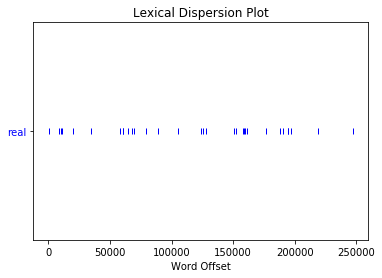

In [208]:
# Pipeline: HTML --> ASCII --> Text --> Vocab
from urllib.request import urlopen
url = "http://www.gutenberg.org/files/2554/old/7crmp10.txt"
## decode
raw = urlopen(url).read().decode('ascii')
## slice
begin = raw.find("PART I")
end = raw.rfind("End of Project Gutenberg's Crime")
raw = raw[begin: end]
## remove html markup
## raw = nltk.clean_html(raw)
## tokenize doc to words
tokens = nltk.word_tokenize(raw)
## convert to nltk.text
text = nltk.Text(tokens)
## inspection
text.concordance('gene')
text.dispersion_plot(words=['real'])

### Regular Expressions

In [268]:
# 1. Detecting Word Patterns  ---  re.search(p, s); p is pattern, s is string; it returns bool
import re
wordlist = [w for w in nltk.corpus.words.words('en') if w.islower()]
# dollar sign ($) matches the end of the word
[w for w in wordlist if re.search('ed$', w)][:5]
# caret symbol ^ matches the start of a string
[w for w in wordlist if re.search('^ab', w)][:5]
# . wildcard symbol matches any single character
[w for w in wordlist if re.search('^..j..t..$', w)]
# ? symbol specifies that the previous character is optional
[w for w in ['email', 'e-mail'] if re.search('^e-?mail$', w)]
sum(1 for w in ['email', 'e-mail'] if re.search('^e-?mail$', w))   # sum num words that matched
# bracket [] create a set to match one of characters in it
[w for w in wordlist if re.search('^[ghi][mno][jlk][def]$', w)]
# - dash inside [] creates range of characters
[w for w in wordlist if re.search('^[a-zA-Z]$', w)][:3]
# + simply means “one or more instances of the preceding item"
chat_words = sorted(set(w for w in nltk.corpus.nps_chat.words()))
[w for w in chat_words if re.search('^m+i+n+e+$', w)][:5]
[w for w in chat_words if re.search('^[ha]+$', w)][:5]
# * is more relaxed, which means “zero or more instances of the preceding item”
[w for w in chat_words if re.search('^[ha]*$', w)][:5]
# \ backslash is for escape purpose
wsj = sorted(set(nltk.corpus.treebank.words()))
[w for w in wsj if re.search('^[0-9]+\.[0-9]+$', w)][:5]    # escape wildcard .
# The braced expressions, like {min, max}, specify the number of repeats of the previous item
[w for w in wsj if re.search('^[0-9]{1,5}$', w)][:5]
[w for w in wsj if re.search('^[0-9]{3,}$', w)][:5]
[w for w in wsj if re.search('^[0-9]{3}$', w)][:5]
[w for w in wsj if re.search('^[0-9]+-[a-z]{3,5}$', w)][:5]
[w for w in wsj if re.search('^[a-z]{5,}-[a-z]{2,3}-[a-z]{,6}$', w)][:5]
# |, pipe character indicates a choice between the material on its left or its right
[w for w in wsj if re.search('ed|ing$', w)][:5]
# (), parentheses indicate the scope of an operator
[w for w in wsj if re.search('w(ed|ing)$', w)][:5]


# 2. Extracting Word Pieces --- re.findall(p, s); p is pattern, s is string; it returns a list of string that matched
# extract vowels
word = 'supercalifragilisticexpialidocious'
re.findall(r'[aeiou]', word)
# count pairs of vowels
wsj = sorted(set(nltk.corpus.treebank.words()))
fd = nltk.FreqDist(vs for word in wsj for vs in re.findall(r'[aeiou]{2,}', word))
fd.items()
# extract word stem --- warnings: this method will find many false positives
## original function
def stem(word):
    for suffix in ['ing', 'ly', 'ed', 'ious', 'ies', 'ive', 'es', 's', 'ment']:
        if word.endswith(suffix):
            return word[:-len(suffix)]
        return word
## regular expression
# () paramthesis will limit the scope and only return the suffix
re.findall(r'^.*(ing|ly|ed|ious|ies|ive|es|s|ment)$', 'processing')
# add ?: in () to increase the scope and extract the whole word
re.findall(r'^.*(?:ing|ly|ed|ious|ies|ive|es|s|ment)$', 'processing')
# add two () to extract both stem and suffix
re.findall(r'^(.*)(ing|ly|ed|ious|ies|ive|es|s|ment)$', 'processing')
# false positive
re.findall(r'^(.*)(ing|ly|ed|ious|ies|ive|es|s|ment)$', 'processes')
# add ? after .* to make it non-greedy
re.findall(r'^(.*?)(ing|ly|ed|ious|ies|ive|es|s|ment)$', 'processes')
# regular expression version function for stemming  ---  still some false postives
def stem(word):
    regexp = r'^(.*?)(ing|ly|ed|ious|ies|ive|es|s|ment)?$'
    stem, suffix = re.findall(regexp, word)[0]
    return stem
raw = """DENNIS: Listen, strange women lying in ponds distributing swords
is no basis for a system of government. Supreme executive power derives from
a mandate from the masses, not from some farcical aquatic ceremony."""
tokens = nltk.word_tokenize(raw)
[stem(t) for t in tokens]

# 3. Search and Extract Pieces from Tokenized Text (list of string) --- use nltk.Text method findall (not from re)
from nltk.corpus import gutenberg, nps_chat
moby = nltk.Text(gutenberg.words('melville-moby_dick.txt'))
# extract adj. matches pattern a (adj.) man --- () define scope for extraction
moby.findall(r"<a> (<.*>) <man>")
# extract the whole pattern, finds three-word phrases ending with the word bro
chat = nltk.Text(nps_chat.words())
chat.findall(r"<.*> <.*> <bro>")
# extract sequences of three or more words starting with the letter l
chat.findall(r"<l.*>{3,}")
# manually discover hypernyms --- will have some false positives
from nltk.corpus import brown
hobbies_learned = nltk.Text(brown.words(categories=['hobbies', 'learned']))
hobbies_learned.findall(r"<\w*> <and> <other> <\w*s>")

you rule bro; telling you bro; u twizted bro
lol lol lol; lmao lol lol; lol lol lol; la la la la la; la la la; la
la la; lovely lol lol love; lol lol lol.; la la la; la la la


### Tokenizing Text  (normalizing / segmentation)

In [23]:
# 1. Naive Normalization -- split on ' ' --> stemming/lemmatize
# word_tokenize
raw = """
DENNIS: Listen, strange women lying in ponds distributing swords
is no basis for a system of government. Supreme executive power derives from
a mandate from the masses, not from some farcical aquatic ceremony.
"""
tokens = nltk.word_tokenize(raw)

# stemming --- Porter and Lancaster
porter = nltk.PorterStemmer()
lancaster = nltk.LancasterStemmer()
[porter.stem(t) for t in tokens]

# lemmatize --- won't break sementic meaning
wnl = nltk.WordNetLemmatizer()
[wnl.lemmatize(t) for t in tokens]


# 2. Use regular expression to tokenize
# split on white space  --- still has space tokens
re.split(r'\W+', raw)
# use re.findall to match tokens  \w: alphanumeric, \S: non-whitespace
re.findall(r'\w+|\S\w*', raw)
# this would additionally include hyphen, ellipsis, and open parenthesis
re.findall(r"\w+(?:[-']\w+)*|'|[-.(]+|\S\w*", raw)

# 3. Use NLTK’s Regular Expression Tokenizer --- similar to re.findall()
text = 'That U.S.A. poster-print costs $12.40...'
pattern = r'''(?x)
([A-Z]\.)+
| \w+(-\w+)*
| \$?\d+(\.\d+)?%?
| \.\.\. # ellipsis
| [][.,;"'?():-_`]
'''
nltk.regexp_tokenize(text, pattern)

# 4. From Lists to Strings
silly = ['We', 'called', 'him', 'Tortoise', 'because', 'he', 'taught', 'us', '.']
' '.join(silly)

'We called him Tortoise because he taught us .'

### NLTK --- POS Tagging

In [15]:
# use nltk pos_tag
text = nltk.word_tokenize("And now for something completely different")
nltk.pos_tag(text)
# look for words that have same tag and in similar part of speech
text = nltk.Text(word.lower() for word in nltk.corpus.brown.words())
text.similar('woman')

# Tagged Corpora in NLTK library
# some corpus in NLTK have tagged text
# internal representation ----> nltk.tag.str2tuple  ----> tuple
nltk.tag.str2tuple('fly/NN')
# open brown corpus with tagged text
nltk.corpus.brown.tagged_words()

# some nltk utils  ---  bigram / trigram
list(nltk.bigrams(nltk.word_tokenize("And now for something completely different")))
list(nltk.trigrams(nltk.word_tokenize("And now for something completely different")))

# The Regular Expression Tagger
patterns = [
    (r'.*ing$', 'VBG'),
    (r'.*ed$', 'VBD'),
    (r'.*es$', 'VBZ'),
    (r'.*ould$', 'MD'),
    (r'.*\'s$', 'NN$'),
    (r'.*s$', 'NNS'),
    (r'^-?[0-9]+(.[0-9]+)?$', 'CD'),
    (r'.*', 'NN')]
regexp_tagger = nltk.RegexpTagger(patterns)
regexp_tagger.tag(nltk.word_tokenize("And now for something completely different"))

# The Lookup Tagger -- look up a dictionary to tag
tags = {'And': 'CC', 'now': 'RB', 'for': 'IN', 'something': 'NN', 'completely': 'RB', 'different': 'JJ'}
lookup_tagger = nltk.UnigramTagger(model=tags, backoff=nltk.DefaultTagger('NN'))
lookup_tagger.tag(nltk.word_tokenize("And now for something completely different"))

"""
Lower level functions
"""
# tag_trainer
# 1). Unigram Tagging  ---  memorized training
from nltk.corpus import brown
brown_tagged_sents = brown.tagged_sents(categories='news')
brown_sents = brown.sents(categories='news')
unigram_tagger = nltk.UnigramTagger(brown_tagged_sents)
unigram_tagger.tag(brown_sents[2007])
unigram_tagger.evaluate(brown_tagged_sents)
# 2). N-Gram Tagging   --  looks at previous word and tag during training
bigram_tagger = nltk.BigramTagger(train_sents)
bigram_tagger.tag(brown_sents[2007])
# bigram suffers sparse data problem
unseen_sent = brown_sents[4203]
bigram_tagger.tag(unseen_sent)
# 3). Combining Taggers using backoff --- fall back on algorithms with wider coverage when necessary
t0 = nltk.DefaultTagger('NN')
t1 = nltk.UnigramTagger(train_sents, backoff=t0)
t2 = nltk.BigramTagger(train_sents, backoff=t1)
t2.evaluate(test_sents)

man time day year car moment world house family child country boy
state job place way war girl work word
